# Visualize adjacency matrix directly

In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn.functional as functional
from torch_geometric.data import Batch, Data, DataLoader
from itertools import product
import pandas as pd
import seaborn as sns
import networkx as nx

In [38]:
import sys
import os
script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")

In [4]:
from collab_env.data.file_utils import expand_path, get_project_root

In [41]:
from collab_env.gnn.gnn import get_adjcency_from_debug_batch, debug_result2prediction
from collab_env.gnn.plotting_utility import load_various_data, load_rollout
from collab_env.sim.boids_gnn_temp.animal_simulation import  static_visualize_2sets, visualize_graph_2sets
from scipy.stats import entropy
from figures.gnn.plot_helpers import plot_weighted_graph

### Load data!

In [87]:
data_names = ['boid_food_basic', 'boid_food_independent'] #'runpod/boid_single_species_basic']

# set short versions of dataset names
data_names_short = {}
data_names_short['boid_single_species_independent'] = 'idpnt'
data_names_short['boid_single_species_basic'] = 'boid'
data_names_short['boid_food_basic'] = 'foodbasic'
data_names_short['boid_food_independent'] = 'foodidpnt'
data_names_short['boid_food_strong'] = 'foodstrong'

In [95]:
datasets = load_various_data(data_names, 1, return_dict = True)

In [96]:
ablation = 0
all_combinations = [
    ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 2, ablation),
    # or ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 0, ablation)
    #    if considering the noised version of the best seed that performed well noiseless
    #    results are the same
    ('boid_food_independent', 'vpluspplus_a', 0.005, 3, 0.5, 4, ablation),
    #('boid_food_strong', 'vpluspplus_a', 0.005, 3, 0.5, 0, ablation)
]

In [97]:
rollout_results =  {}

model_names = {}
for ind in range(len(all_combinations)):

    data_name, model_name, n, h, vr, s, ablation = all_combinations[ind]

    print("ablation ", ablation)

    #if ablation:
    #    old_format = True
    #else:
    old_format = False
    spec = {
        "data_name": data_name,
        "head": h,
        "visual_range": vr,
        "seed": s,
        "rollout_starting_frame": 5,
        "noise": n,
        "seed": s,
        "old_format": old_format,
        "ablate": ablation
    }
    
    data_name_short = data_names_short[data_name]
    if ablation:
        model_save_name = f'{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}_ablation'
    else:
        model_save_name = f'{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}'

    
    #try:
        
    rollout_results[ind] = load_rollout(
            "vpluspplus_a", **spec)
    model_names[ind] = model_save_name
    print(f"{ind}, Successfully import {model_save_name}")
    #except:
    #    print(f"Cannot import {model_save_name}")


ablation  0
0, Successfully import foodbasic_
n0.005_h3_vr0.5_s2
ablation  0
1, Successfully import foodidpnt_
n0.005_h3_vr0.5_s4


### Parse adjacency matrix

In [101]:
models_to_consider = [0,1] #rollout_results.keys()
print(models_to_consider)

[0, 1]


In [102]:
print(model_names)
assert len(model_names) == len(rollout_results.keys())

{0: 'foodbasic_\nn0.005_h3_vr0.5_s2', 1: 'foodidpnt_\nn0.005_h3_vr0.5_s4'}


In [103]:
STARTING_FRAME = 5
ENDING_FRAME = 55
MODEL_STARTING_FRAME = 3
NODE_NUM = 21 # 21 boids + 1 food

entropy_dict = {}
ratio_dict = {}
W_output_all = {}
W_input_all = {}

for m in models_to_consider: #rollout_results:
    print(f"Parsing model {m}")
    
    dataname, model_name, n, h, vr, s, _ = all_combinations[ind]
    dataloader = datasets[dataname]["test_loader"]
    
    W_input, W_output = get_adjcency_from_debug_batch(
            rollout_results[m], dataloader, vr, STARTING_FRAME, ENDING_FRAME, MODEL_STARTING_FRAME, NODE_NUM
        )

    W_output_all[m] = W_output
    W_input_all[m] = W_input

Parsing model 0
Parsing model 1


### Do plottings

In [104]:
ep = 0

### Pick a model

In [127]:
m = 0

### Pick a file

In [128]:
file_id = 10

In [129]:
actual_pos, actual_vel, actual_acc, gnn_pos, gnn_vel, gnn_acc, frame_sets = debug_result2prediction(
                    rollout_results[m],
                    file_id = file_id, epoch_num = 0)


### Pick a frame

In [130]:
frame_in_rollout = 10

In [131]:
starting_frame = 3
rolling_out = 5
frame = frame_in_rollout + rolling_out - starting_frame

### Make plot

In [132]:
# adjacency matrix
W_f = W_output_all[m][ep][file_id][frame] #W for this frame
Win_f = W_input_all[m][ep][file_id][frame] #W for this frame

# positions of nodes for this frame
gnn_pos_f = gnn_pos[0, frame] #0 is for the first batch
pos_dict = {}
for n in range(gnn_pos_f.shape[0]):
    pos_dict[n] = (gnn_pos_f[n,0], gnn_pos_f[n,1])

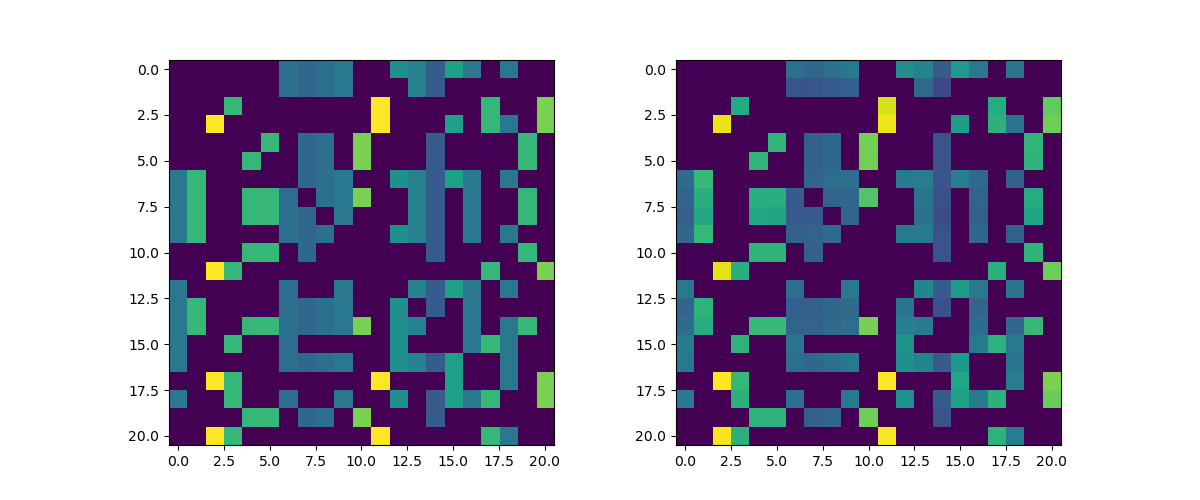

In [133]:
%matplotlib widget
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
axes[0].imshow(Win_f)
axes[1].imshow(W_f)
plt.show()

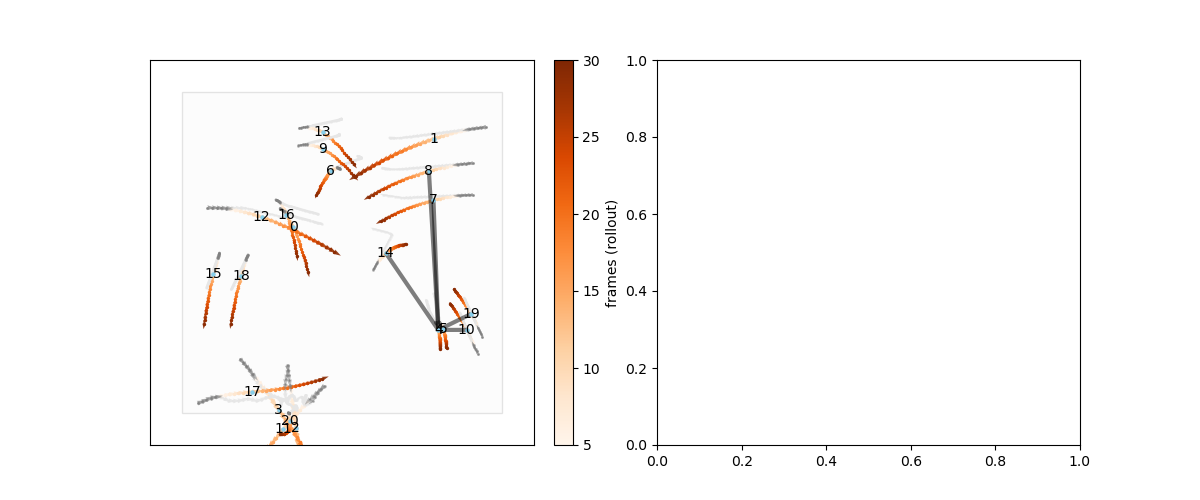

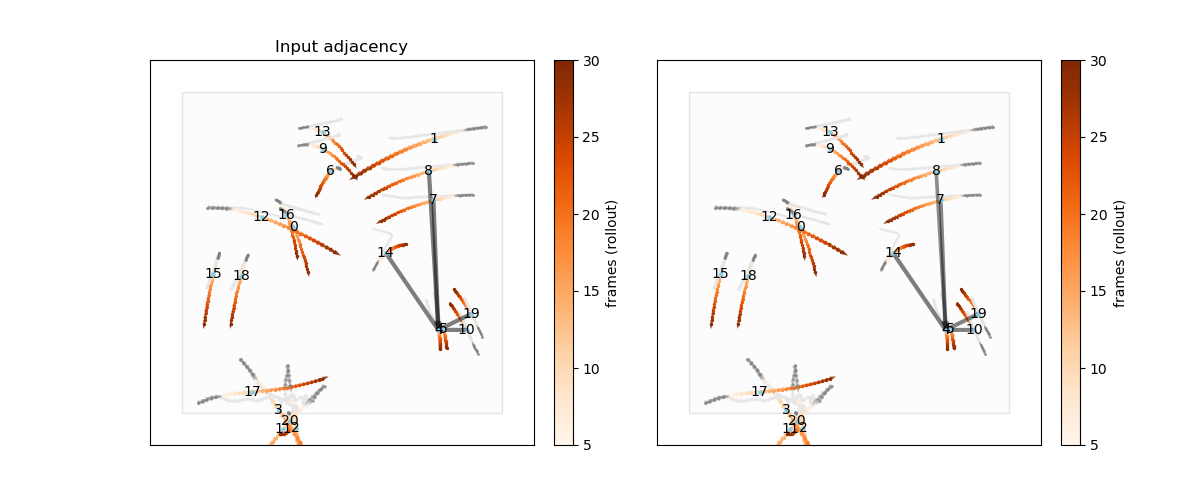

Text(0.5, 1.0, 'Output adjacency')

In [134]:
%matplotlib widget

starting_frame = 0
rollout_starting_frame = 5
ending_frame = 30
node = 4

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

ax = static_visualize_2sets(actual_pos[0], actual_vel[0], gnn_pos[0], gnn_vel[0], fig = fig, ax = axes[0],
                starting_frame = starting_frame, rollout_starting_frame = rollout_starting_frame, 
                ending_frame = ending_frame)

plot_weighted_graph(pos_dict, Win_f, ax, [node])
axes[0].set_title(f'Input adjacency')

ax = static_visualize_2sets(actual_pos[0], actual_vel[0], gnn_pos[0], gnn_vel[0], fig = fig, ax = axes[1],
                starting_frame = starting_frame, rollout_starting_frame = rollout_starting_frame, 
                ending_frame = ending_frame)

plot_weighted_graph(pos_dict, W_f, ax, [node])
axes[1].set_title(f'Output adjacency')


### Gifs

p0 shape torch.Size([21, 2])
p shape torch.Size([302, 21, 2])


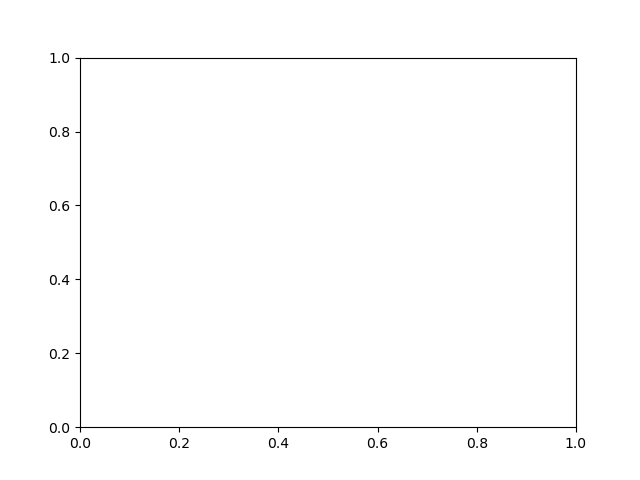

In [135]:
%matplotlib widget
W = W_output_all[m][ep][file_id]
#W = W_input_all[m][ep][file_id]
ani, ax = visualize_graph_2sets(actual_pos[0], actual_vel[0] * 10, gnn_pos[0], gnn_vel[0] * 10,
                      starting_frame = 0,
                      ending_frame = len(W),
                      adj = W, plot_node = [node])
#plot_weighted_graph(pos_dict, Win_f, ax, [node])

In [136]:
dataname, model_name, n, h, vr, s, _ = all_combinations[m]
folder = "/workspace/collab-environment/figures/gnn/"
save_name = f"{folder}{dataname}_{model_name}_n{n}_h{h}_vr{vr}_s{s}.gif"

MovieWriter imagemagick unavailable; using Pillow instead.


here


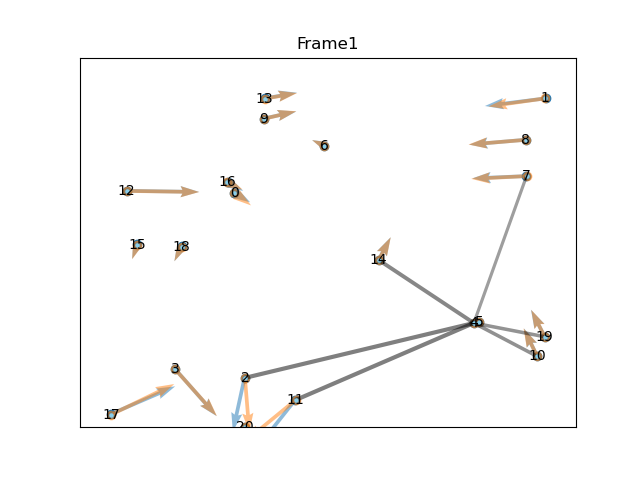

here


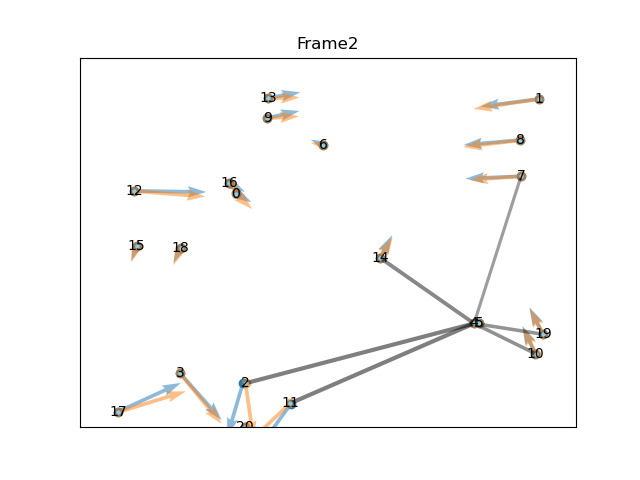

here


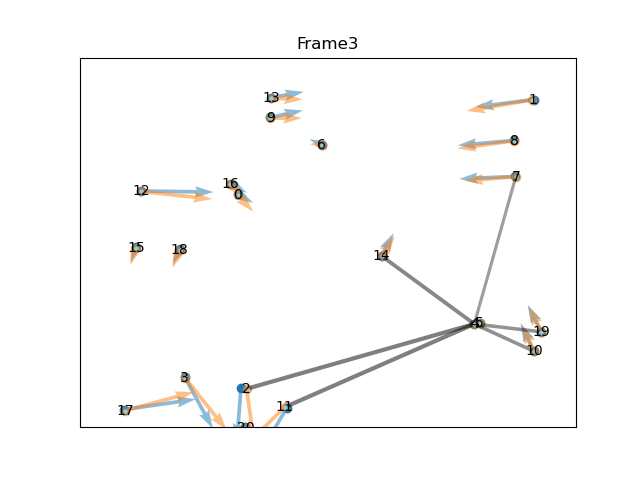

here


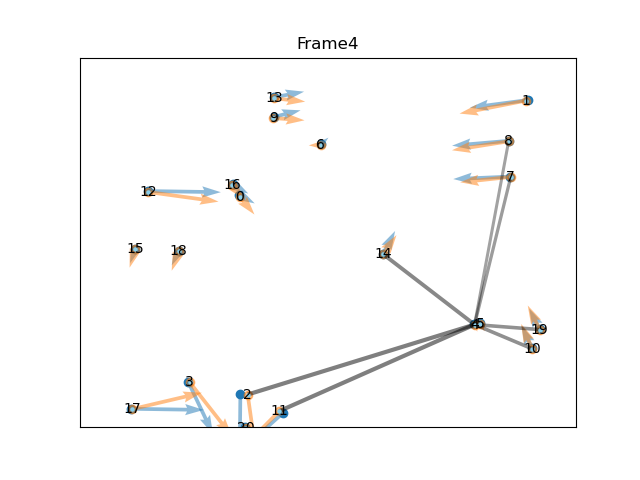

here


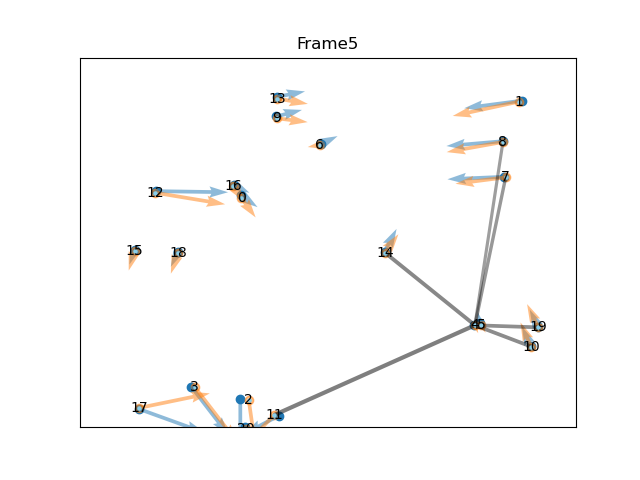

here


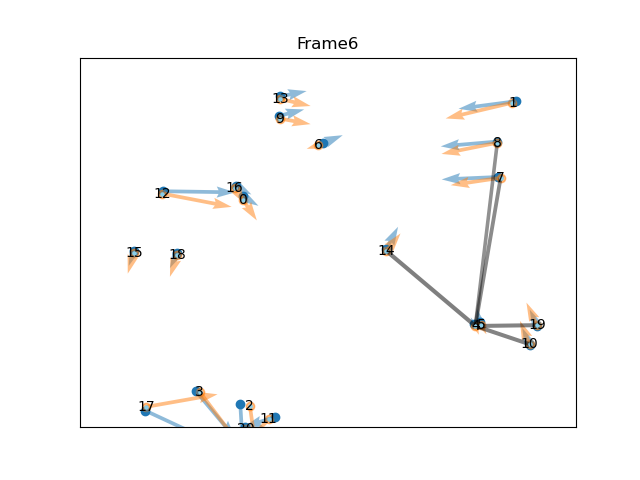

here


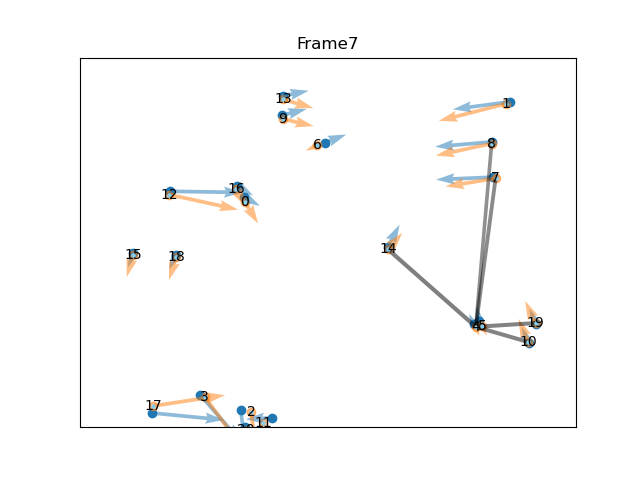

here


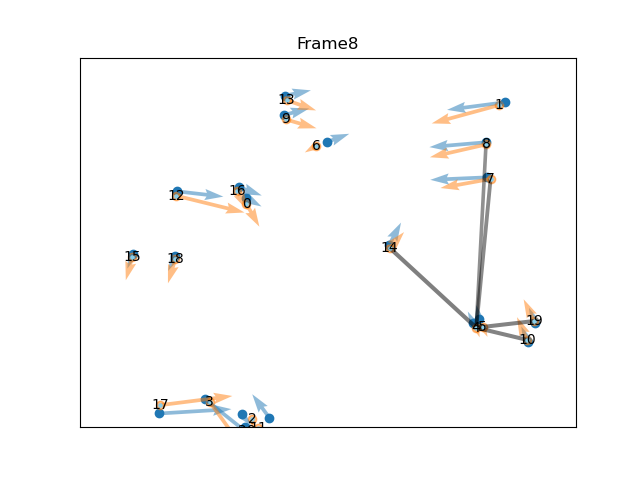

here


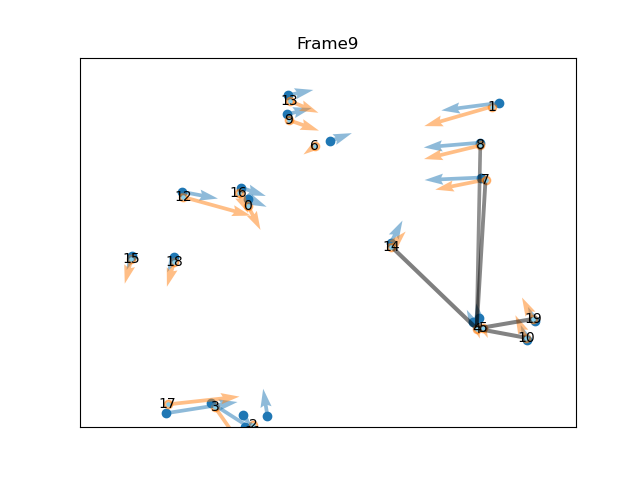

here


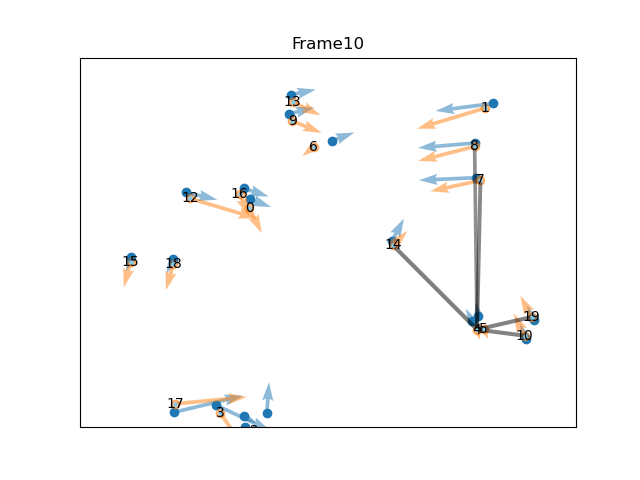

here


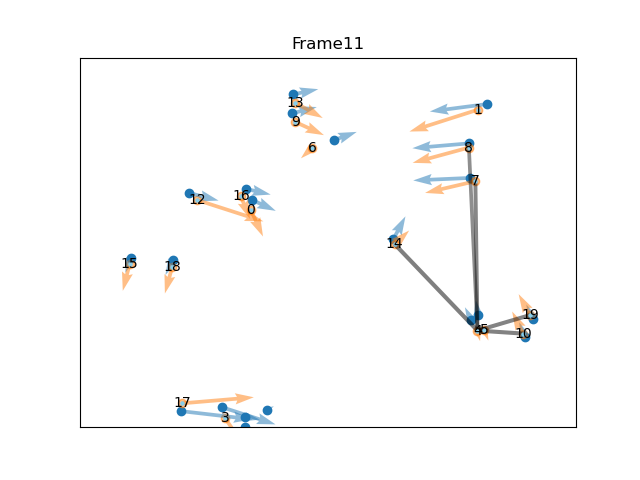

here


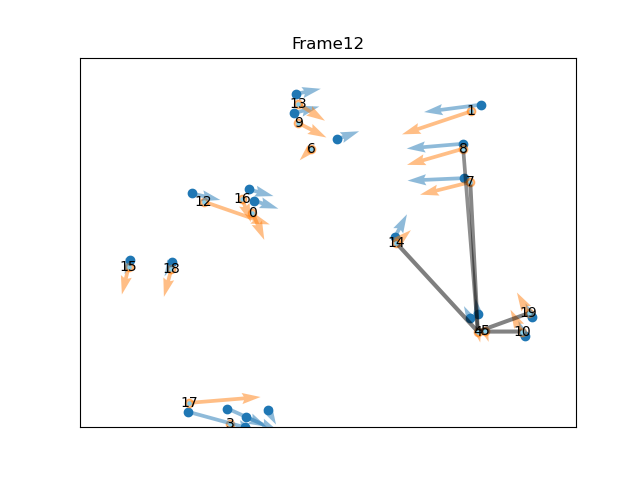

here


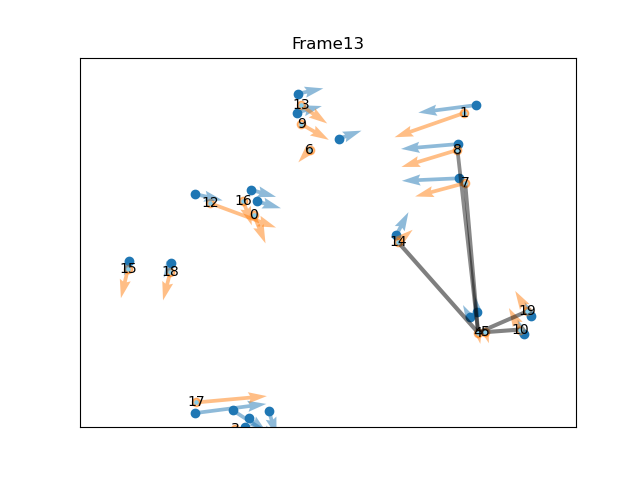

here


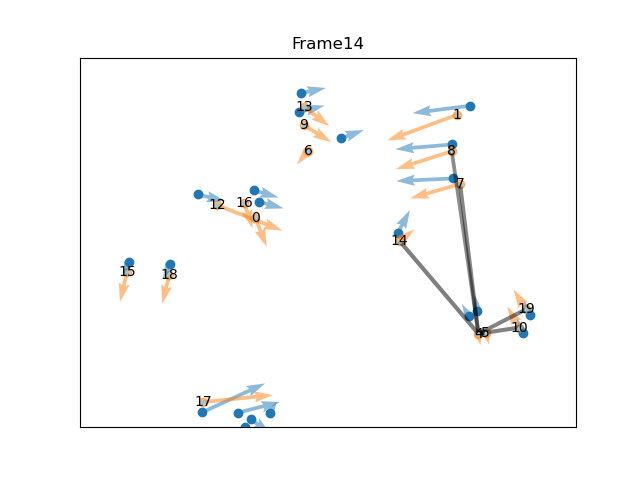

here


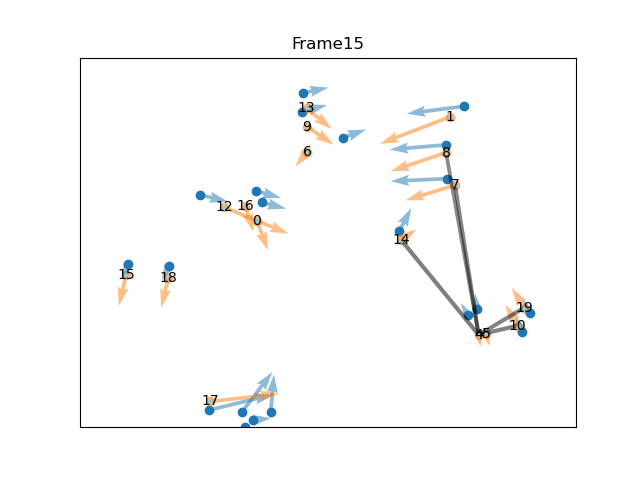

here


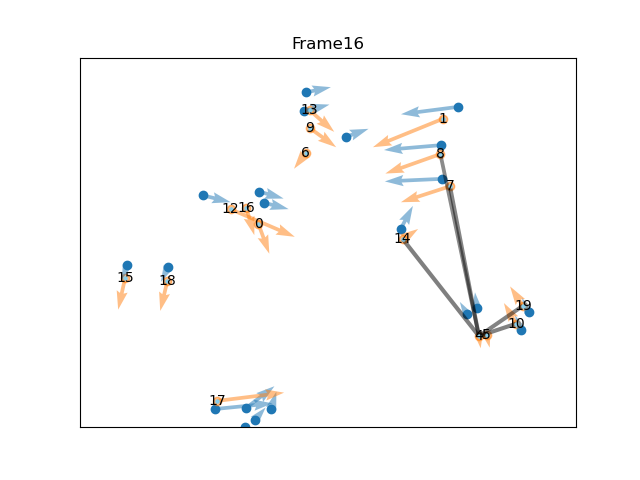

here


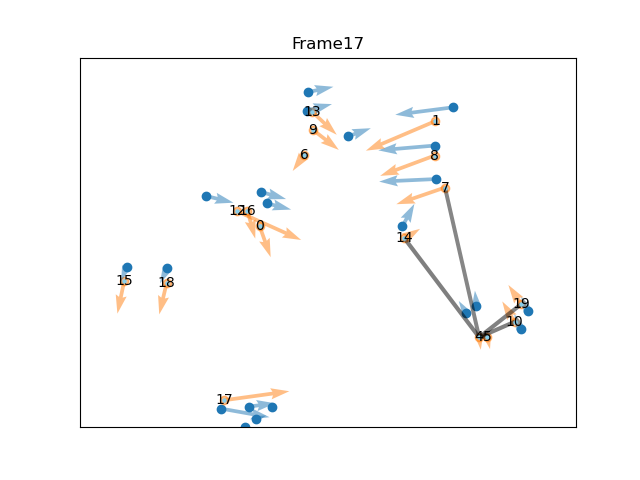

here


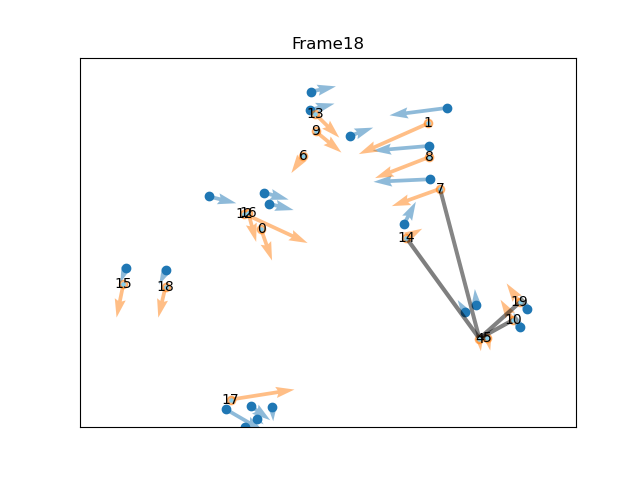

here


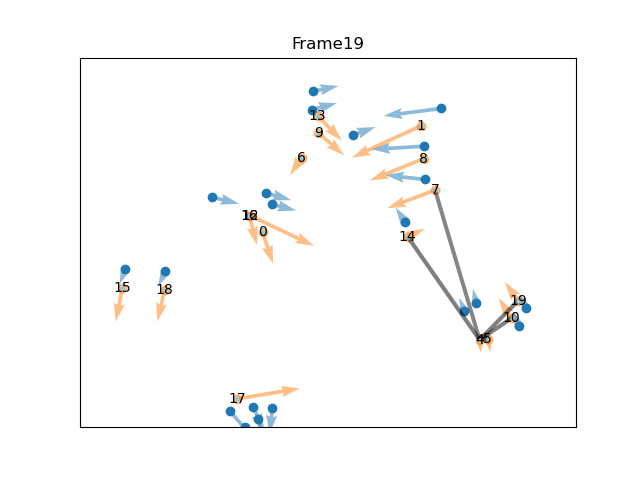

here


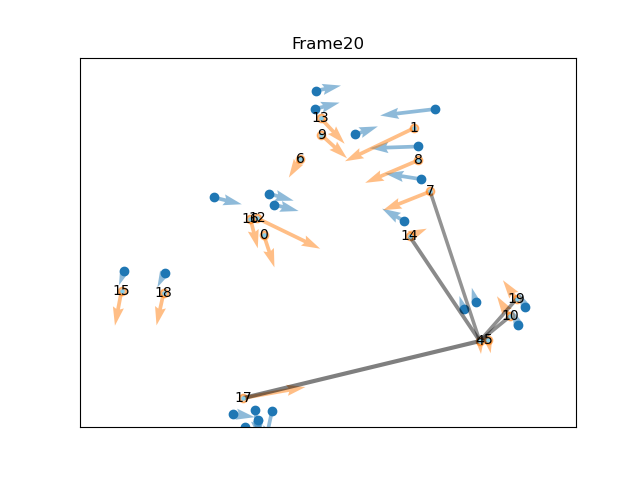

here


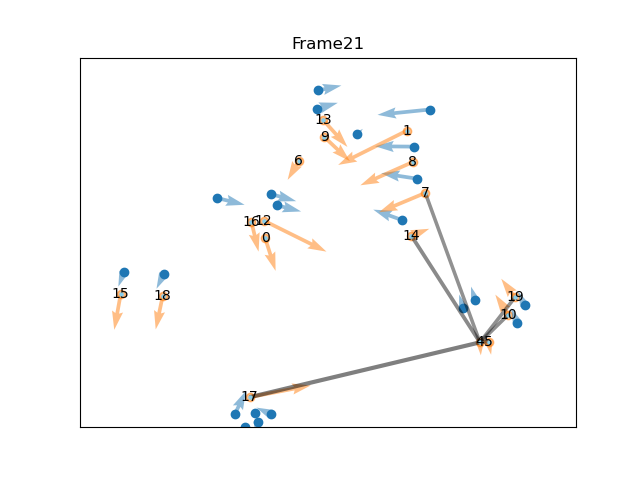

here


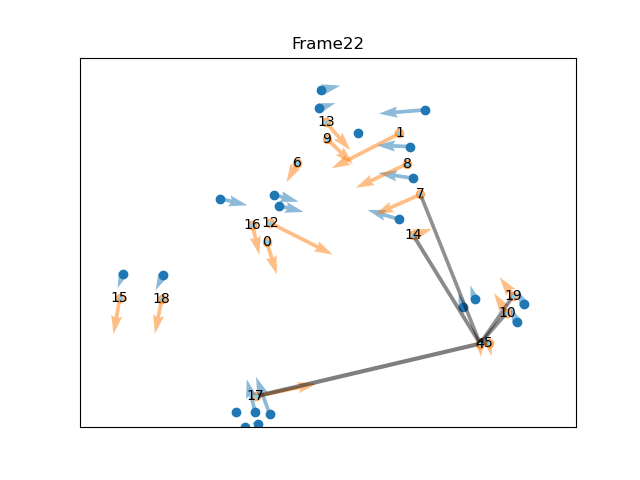

here


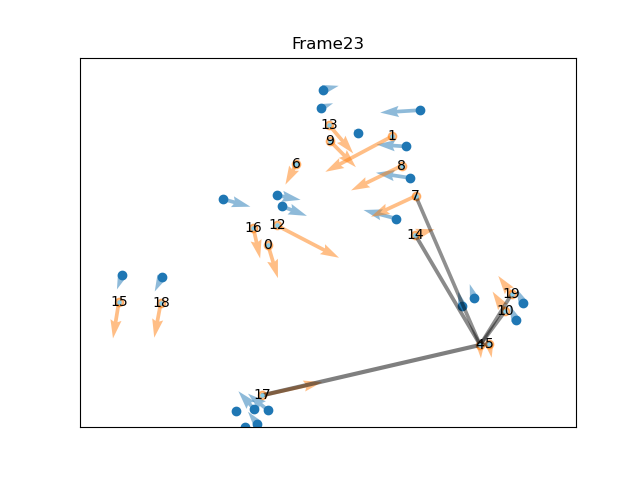

here


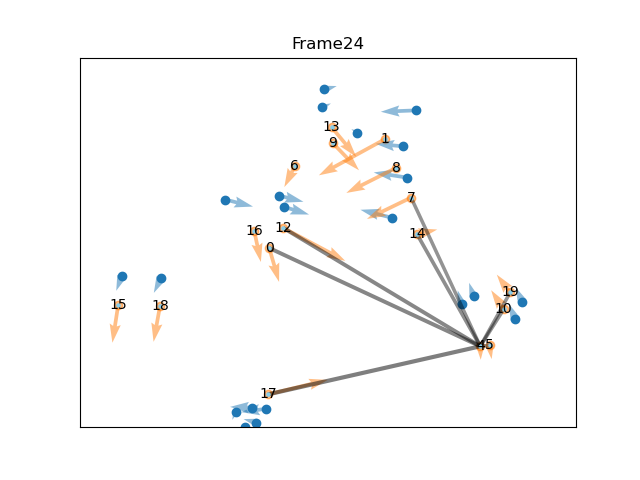

here


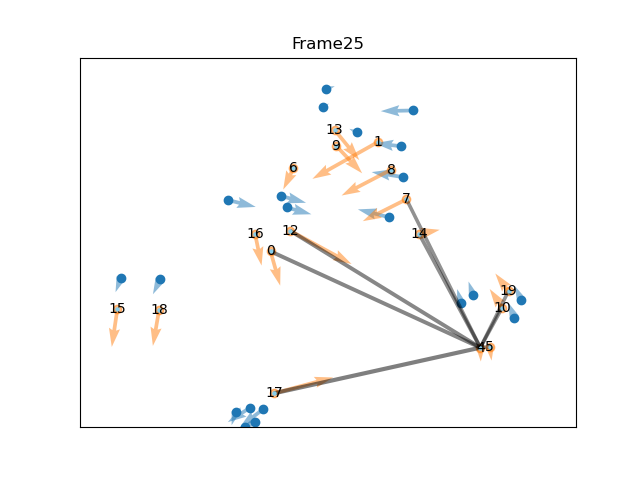

here


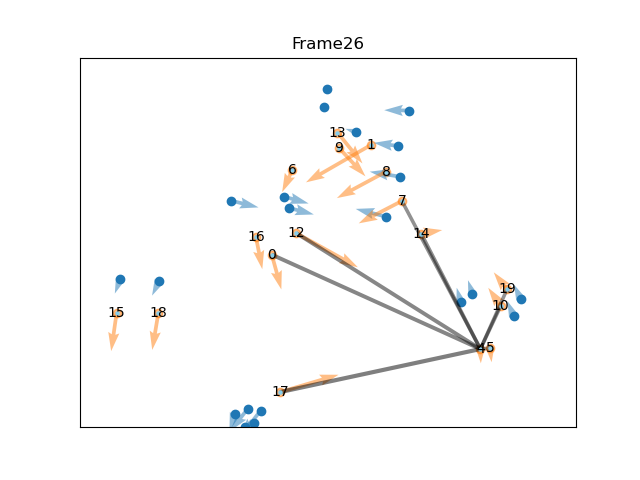

here


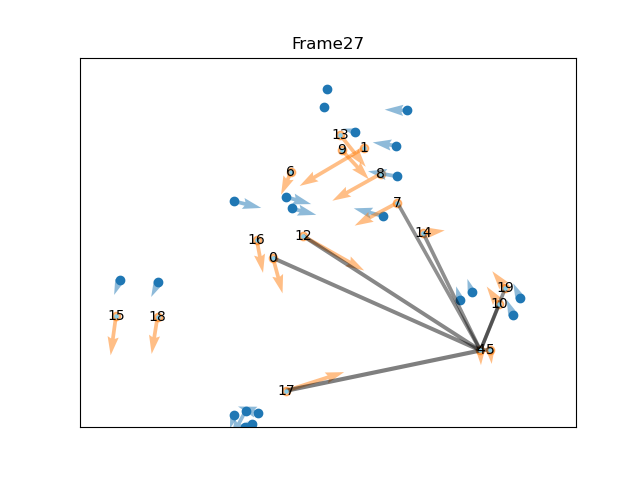

here


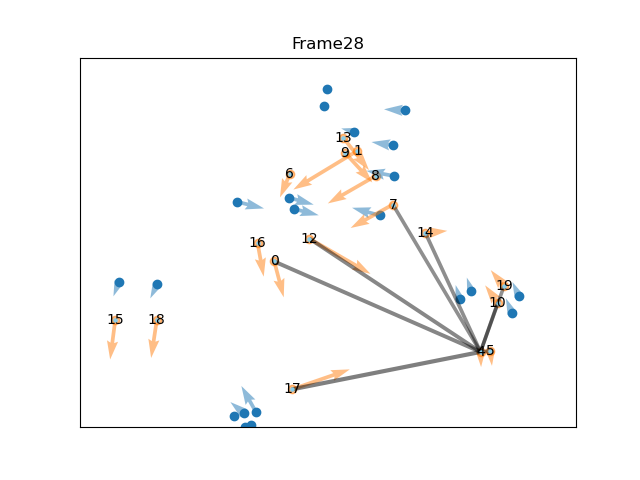

here


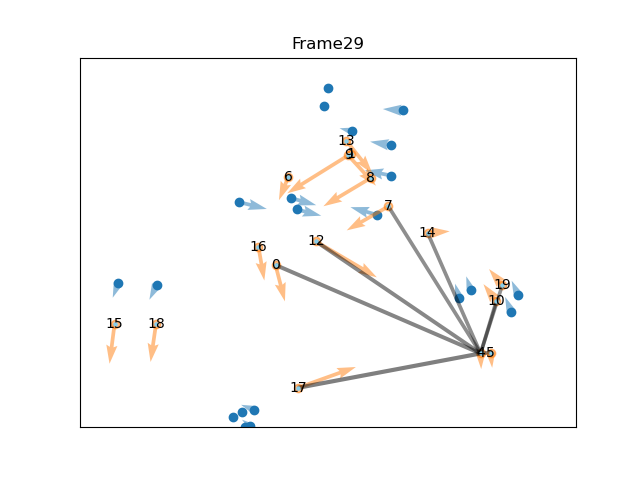

here


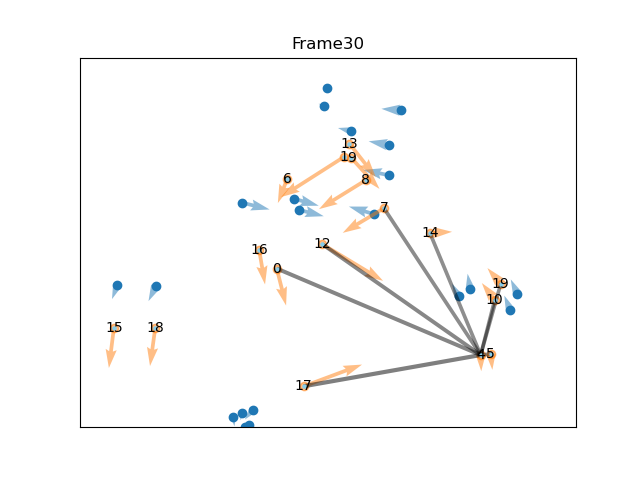

here


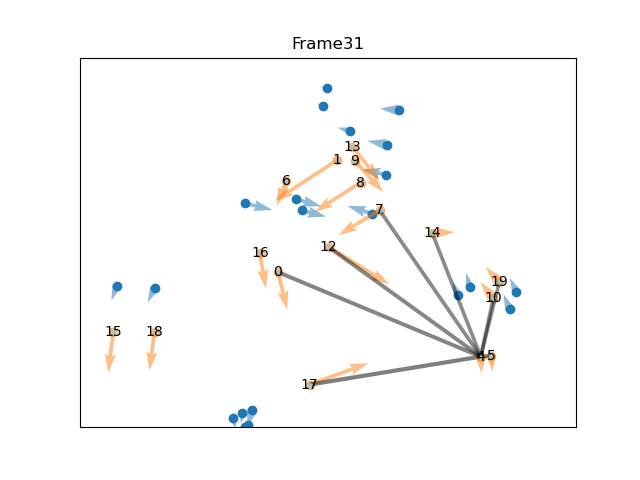

here


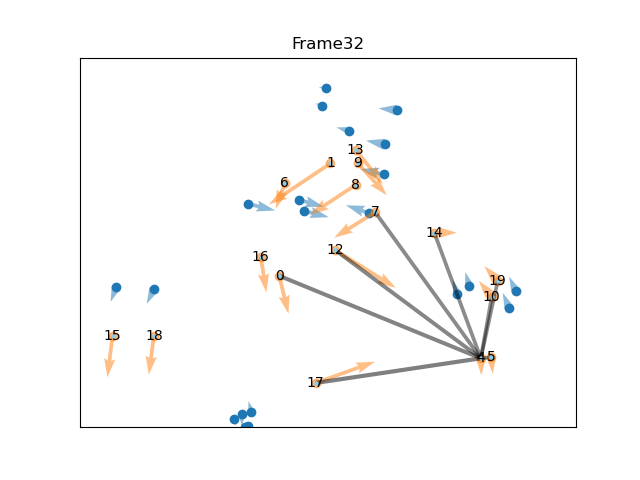

here


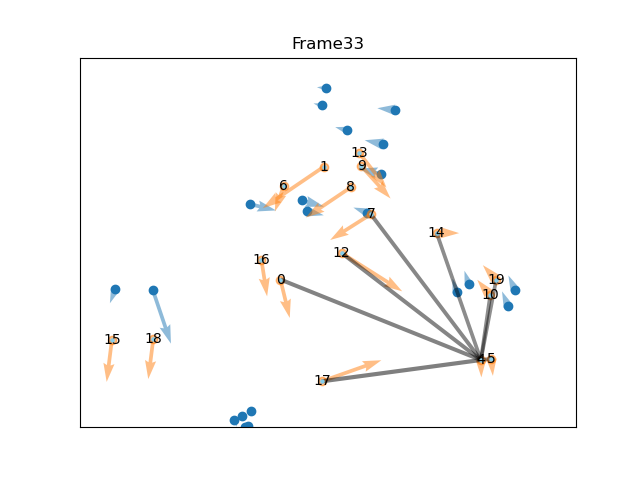

here


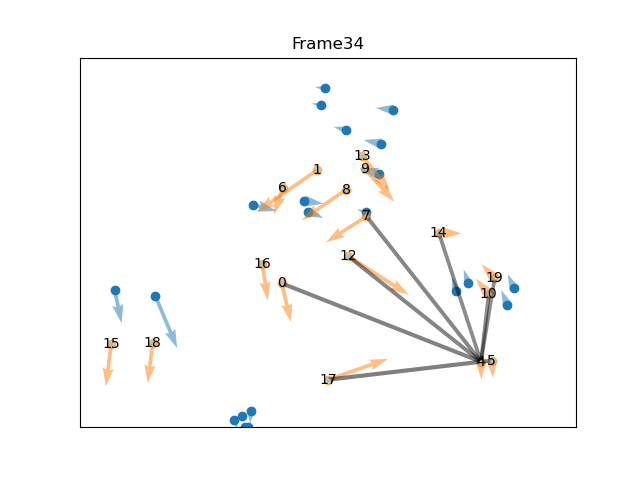

here


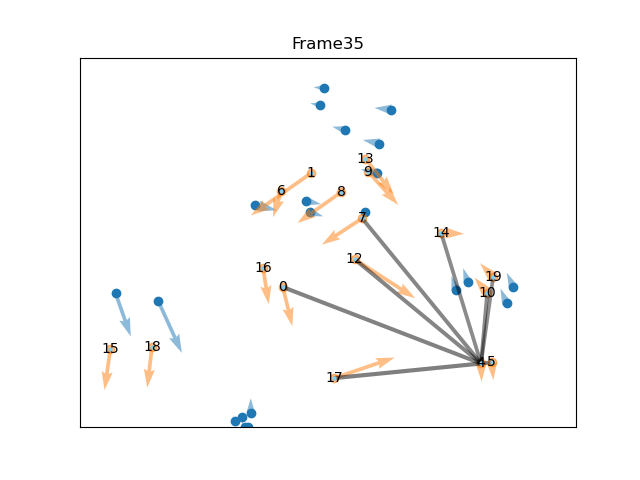

here


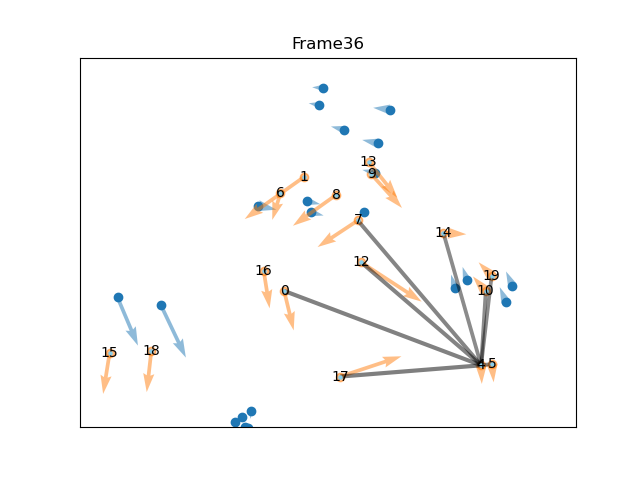

here


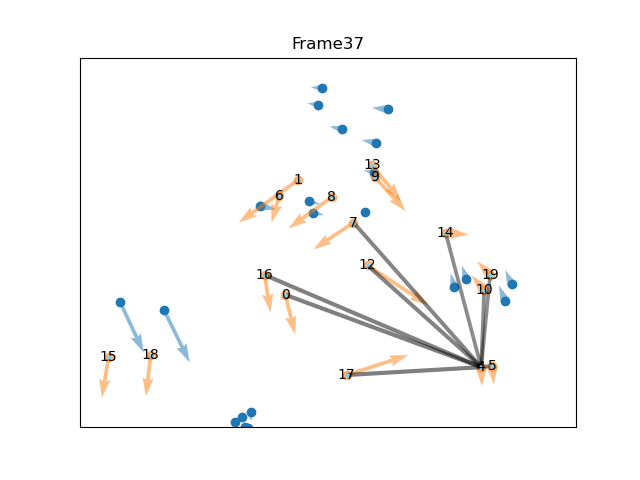

here


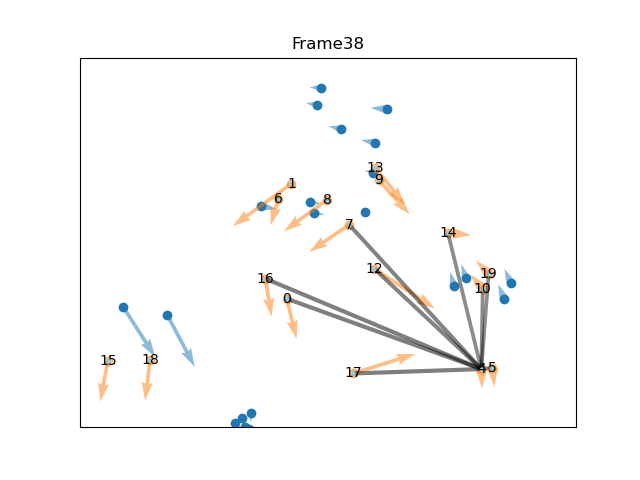

here


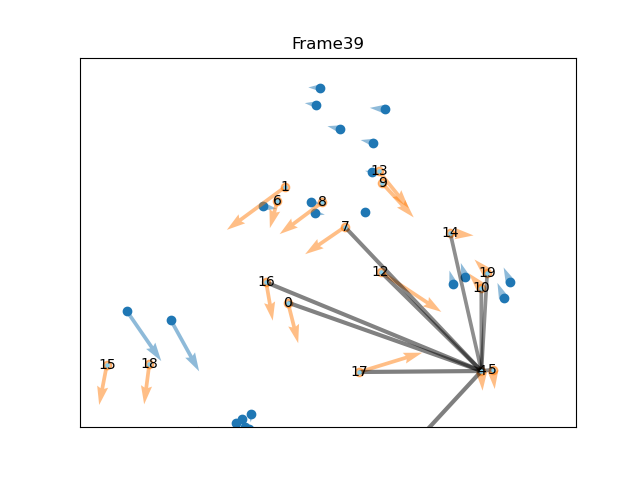

here


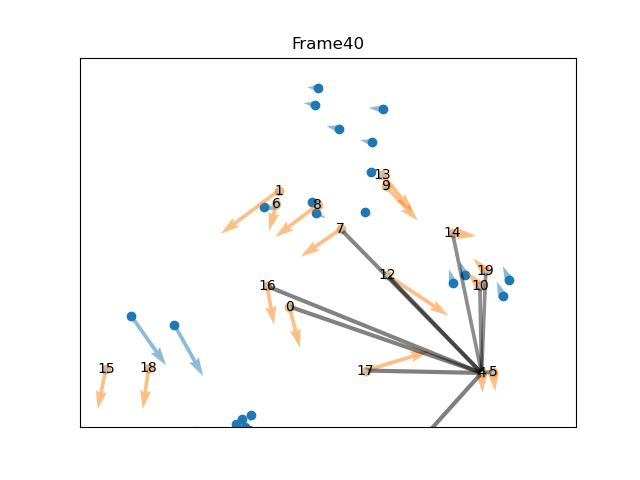

here


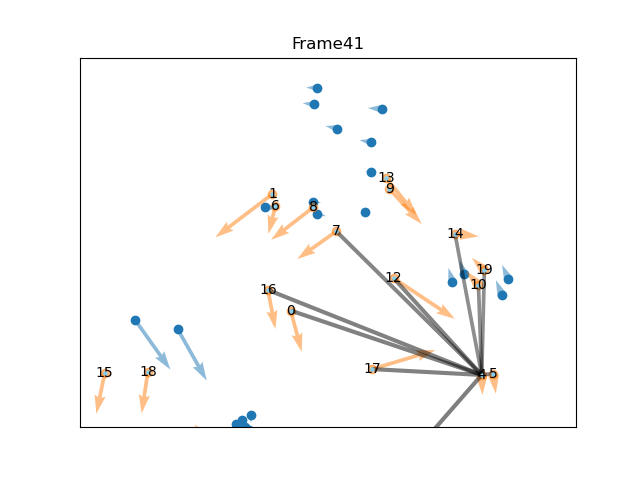

here


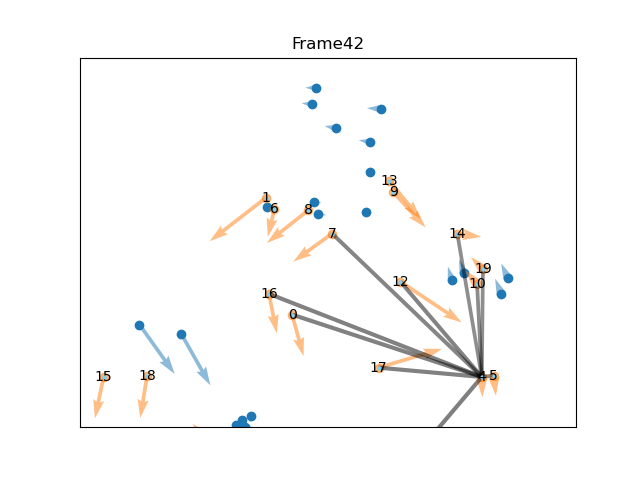

here


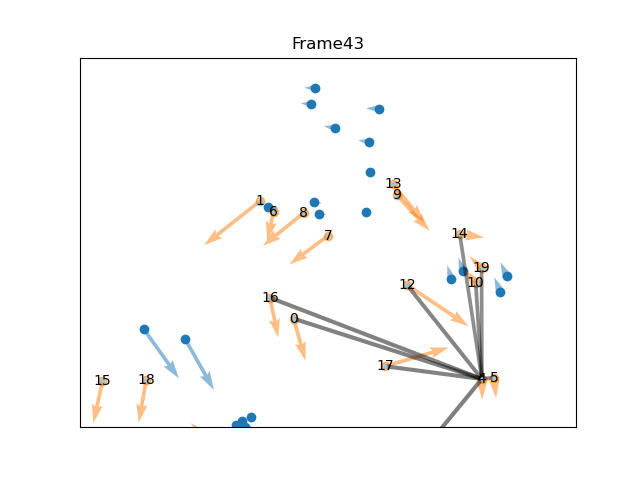

here


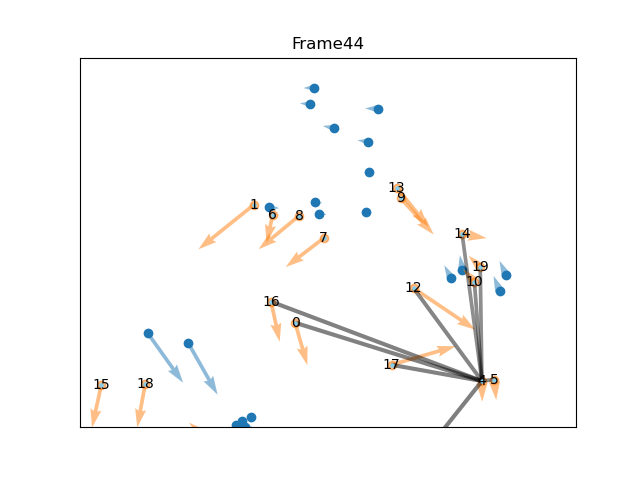

here


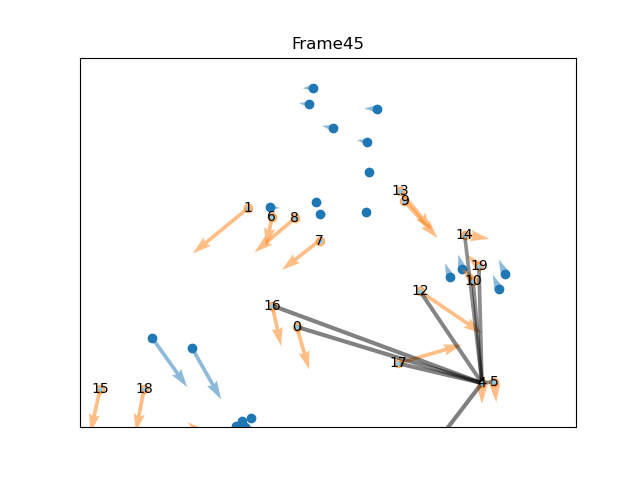

here


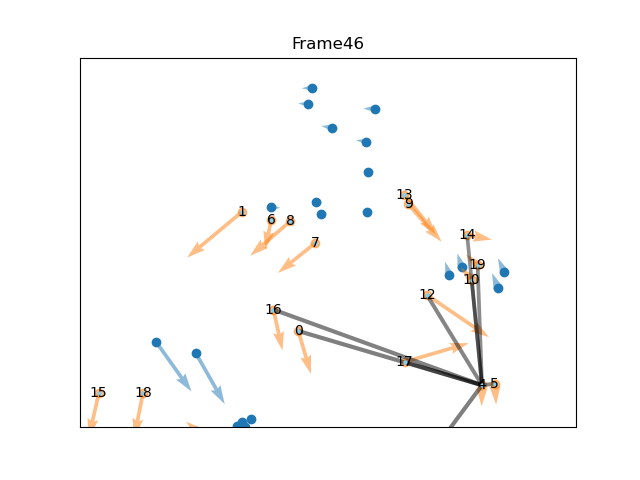

here


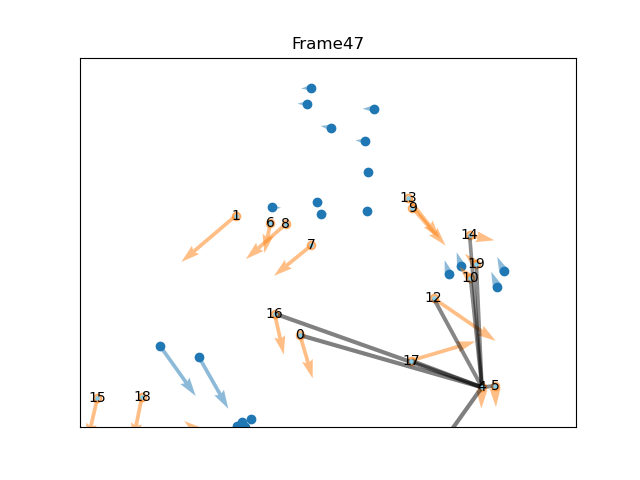

here


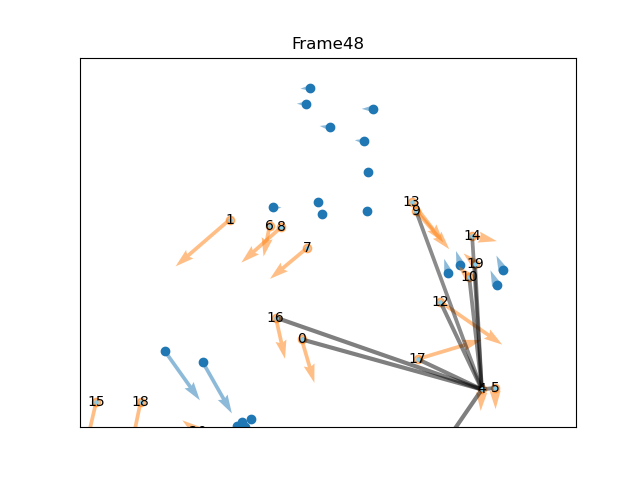

here


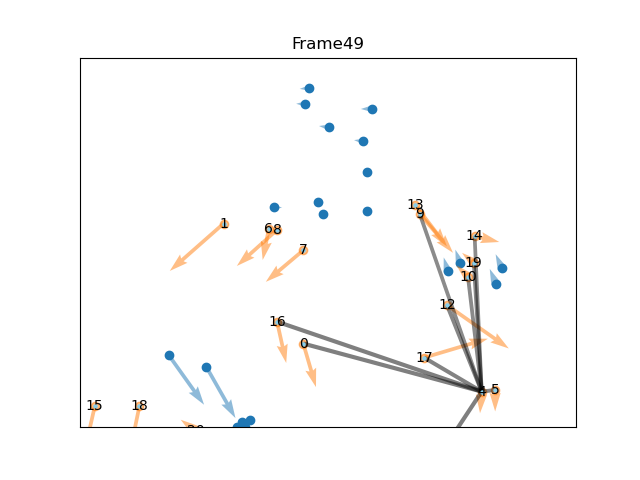

In [137]:
ani.save(save_name, writer='imagemagick', fps=10)